# Polynomial Regression Implementation

# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import scipy
from scipy import linalg # QR DECOMPOSITION

# Utility Functions

## Metrics

In [2]:
def get_mse(y_real, y_pred):
    return np.mean((y_real - y_pred) ** 2)

def get_rmse(y_real, y_pred):
    return np.sqrt(get_mse(y_real, y_pred))

## Standardization

In [3]:
class StandardScaler:
    def __init__(self):
        self.fitted = False

    def fit_transform(self, data):      
        self.mean = data.mean(axis=0)
        self.std = data.std(axis=0)
        self.fitted = True

        scaled_data = (data - self.mean) / self.std
        return scaled_data
    
    def transform(self, data):
        if not self.fitted:
            raise Exception('Scaler not fitted!')

        scaled_data = (data - self.mean) / self.std
        return scaled_data

    def inverse_transform(self, scaled_data):
        if not self.fitted:
            raise Exception('Scaler not fitted!')
        
        original_data = (scaled_data * self.std) + self.mean
        return original_data


## Min-max feature scaling

In [4]:
class MinMaxScaler:
    def __init__(self):
        self.fitted = False

    def fit_transform(self, data):      
        self.maximum = data.max(axis=0)
        self.minimum = data.min(axis=0)
        self.fitted = True

        scaled_data =  (data - self.minimum) / (self.maximum - self.minimum)
        return scaled_data
    
    def transform(self, data):
        if not self.fitted:
            raise Exception('Scaler not fitted!')

        scaled_data =  (data - self.minimum) / (self.maximum - self.minimum)
        return scaled_data

    def inverse_transform(self, scaled_data):
        if not self.fitted:
            raise Exception('Scaler not fitted!')
        
        original_data = (self.maximum - self.minimum) * scaled_data + self.minimum
        return original_data

# Polynomial Regression
Consider the dataset available in california.csv, organized into 9 columns, the 8 first being the independent variables (features) and the last column the dependent variable (target).
The dependent variables are used to predict the median of house prices in California districts in the 1990s.

- a) Randomly split the dataset in training (80%) and test (20%) 
- b) Train 11 polynomial regression models, with degrees from 1 to 11. You can you OLS algorithm to do this task.
- c) Report the RMSE of train and test for each model. Plot one chart to train and one chart to test.
- d) Repeat the previous 2 itens including the regularization term L2 (eg with factor λ = 0.001)

In [21]:
class MyPolynomialRegression:
    def __init__(self, polynomial_degree):
        self.polynomial_degree = polynomial_degree
        self.fitted = False


    def insert_polynomial_features(self, X):
        intercept = X[:, [0]]
        features = X[:, 1:]

        X_poly = features
        if self.polynomial_degree > 1:
            for i in range(2, self.polynomial_degree+1):
                X_poly = np.hstack([X_poly, features**i])
        
        X_poly = np.hstack([intercept, X_poly])

        return X_poly


    # Fit with OLS
    def fit_ols(self, X, y, reg_lambda=0):
        if not all(X[:, 0] == 1):
            raise Exception('The first column must be the intercept column (X[0])')

        X = self.insert_polynomial_features(X)

        self.X_scaler = StandardScaler()
        X = np.hstack([X[:, [0]], self.X_scaler.fit_transform(X[:, 1:])])
        self.y_scaler = StandardScaler()
        y = self.y_scaler.fit_transform(y)

        matrix_to_mitigate_numerical_problems = (10 ** -8) * np.eye(X.shape[1], X.shape[1])
        reg_matrix = np.eye(X.shape[1], X.shape[1]) * reg_lambda
        reg_matrix[0, 0] = 0

        w_hat = (np.linalg.pinv(X.T @ X + reg_matrix + matrix_to_mitigate_numerical_problems) @ X.T) @ y
        self.w = w_hat.reshape(-1, 1)
        self.fitted = True


    def predict(self, X):
        if self.fitted:
            if not all(X[:, 0] == 1):
                raise Exception('The first column must be the intercept column (X[0])')
            
            X = self.insert_polynomial_features(X)
            X = np.hstack([X[:, [0]], self.X_scaler.transform(X[:, 1:])])

            y_pred = (X @ self.w).reshape(-1, 1)
            y_pred = self.y_scaler.inverse_transform(y_pred)

            return y_pred
        else:
            raise Exception('Model not fitted!')


In [22]:
california_data = np.genfromtxt('../data/california.csv', delimiter=',')

print('Visualizing data')
california_data[:2,:]

Visualizing data


array([[   4.1685    ,   20.        ,    6.70063694,    1.17834395,
         745.        ,    2.37261146,   38.8       , -121.15      ,
           2.175     ],
       [   2.8194    ,   24.        ,    4.7625    ,    1.02083333,
         608.        ,    2.53333333,   36.75      , -119.85      ,
           0.811     ]])

In [23]:
def train_test_split(data, train_size_perc, random_seed=264852):
    N = data.shape[0]
    train_size = int(train_size_perc * N)

    indexes = np.arange(0, N, 1)

    np.random.seed(random_seed)
    train_idx = np.random.choice(indexes, train_size, replace=False)
    test_idx = np.delete(indexes, train_idx)

    train_data = data[train_idx]
    test_data = data[test_idx]

    X_train = train_data[:,:-1]
    y_train = train_data[:,[-1]]

    X_test = test_data[:,:-1]
    y_test = test_data[:,[-1]]

    return X_train, X_test, y_train, y_test


X_train, X_test, y_train, y_test = train_test_split(california_data, 0.8)
print('X_train shape:', X_train.shape)
print('y_train shape:', y_train.shape)
print('X_test shape:', X_test.shape)
print('y_test shape:', y_test.shape)

X_train shape: (4000, 8)
y_train shape: (4000, 1)
X_test shape: (1000, 8)
y_test shape: (1000, 1)


## Without Regularization

In [24]:
rmse_train_list = []
rmse_test_list = []

for i in range(11):
    my_poly_reg = MyPolynomialRegression(polynomial_degree=i+1)

    # Training model
    X_train_temp = np.hstack([np.ones((len(X_train),1)), X_train])
    my_poly_reg.fit_ols(X_train_temp, y_train, reg_lambda=0)

    # Predicting y_train
    y_train_pred = my_poly_reg.predict(X_train_temp)
    rmse_train_list.append(get_rmse(y_train, y_train_pred))

    # Predicting y_test
    X_test_temp = np.hstack([np.ones((len(X_test),1)), X_test])
    y_test_pred = my_poly_reg.predict(X_test_temp)
    rmse_test_list.append(get_rmse(y_test, y_test_pred))

rmse_train_list = np.array(rmse_train_list)
rmse_test_list = np.array(rmse_test_list)

In [25]:
print('Polynomial Regression')
print('----------------------------------')
print('Degree\tRMSE(Training)\tRMSE(Test)')
print('----------------------------------')
for i, row in enumerate(zip(rmse_train_list, rmse_test_list)):
    print('{0:<8}{1:<16.8f}{2:<16.6f}'.format(i+1, row[0], row[1]))

Polynomial Regression
----------------------------------
Degree	RMSE(Training)	RMSE(Test)
----------------------------------
1       0.72322157      0.720783        
2       0.66942386      0.669167        
3       0.63777556      0.783326        
4       0.63049649      1.496323        
5       0.62816813      1.116712        
6       0.62620750      1.514245        
7       0.62128935      113.901037      
8       0.62020693      732.427300      
9       0.62019547      839.689869      
10      0.62005297      159.077822      
11      0.61955820      2661.916207     


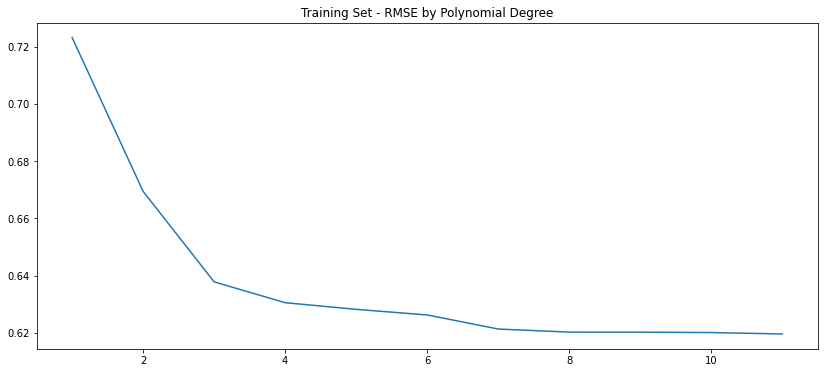

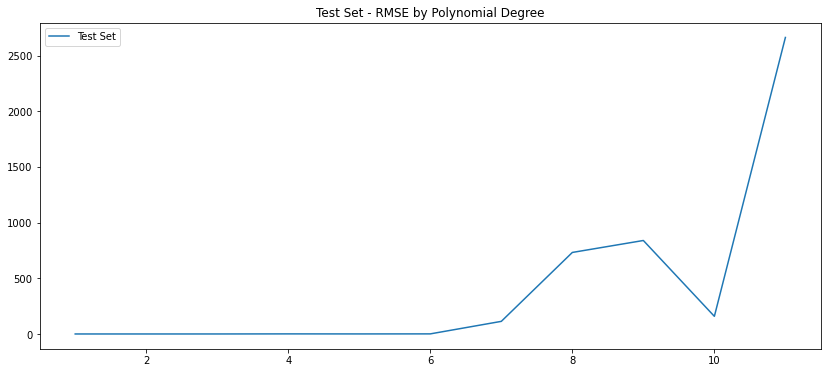

In [29]:
plt.figure(figsize=(14,6))
plt.title('Training Set - RMSE by Polynomial Degree')
plt.plot(range(1,12), rmse_train_list, label='Training Set')
plt.figure(figsize=(14,6))
plt.title('Test Set - RMSE by Polynomial Degree')
plt.plot(range(1,12), rmse_test_list, label='Test Set')
plt.legend()
plt.show()

## With Regularization (lambda=0.001)

In [30]:
rmse_train_list = []
rmse_test_list = []

for i in range(11):
    my_poly_reg = MyPolynomialRegression(polynomial_degree=i+1)

    # Training model
    X_train_temp = np.hstack([np.ones((len(X_train),1)), X_train])
    my_poly_reg.fit_ols(X_train_temp, y_train, reg_lambda=0.001)

    # Predicting y_train
    y_train_pred = my_poly_reg.predict(X_train_temp)
    rmse_train_list.append(get_rmse(y_train, y_train_pred))

    # Predicting y_test
    X_test_temp = np.hstack([np.ones((len(X_test),1)), X_test])
    y_test_pred = my_poly_reg.predict(X_test_temp)
    rmse_test_list.append(get_rmse(y_test, y_test_pred))

rmse_train_list = np.array(rmse_train_list)
rmse_test_list = np.array(rmse_test_list)

In [31]:
print('Polynomial Regression with L2 Regularization (lambda=0.001)')
print('----------------------------------')
print('Degree\tRMSE(Training)\tRMSE(Test)')
print('----------------------------------')
for i, row in enumerate(zip(rmse_train_list, rmse_test_list)):
    print('{0:<8}{1:<16.8f}{2:<16.6f}'.format(i+1, row[0], row[1]))

Polynomial Regression with L2 Regularization (lambda=0.001)
----------------------------------
Degree	RMSE(Training)	RMSE(Test)
----------------------------------
1       0.72322157      0.720783        
2       0.66942424      0.669181        
3       0.65069351      0.768951        
4       0.64674961      1.418320        
5       0.64495673      0.837795        
6       0.64441665      1.124933        
7       0.64404116      8.969059        
8       0.64318765      31.159555       
9       0.64206431      72.894065       
10      0.64124400      129.035566      
11      0.64088871      168.668157      


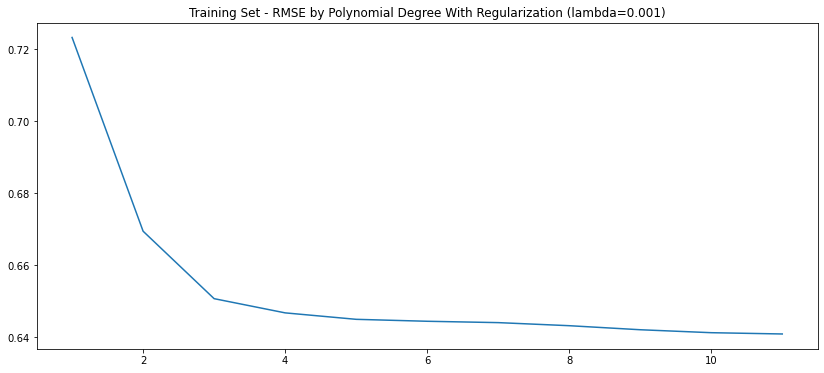

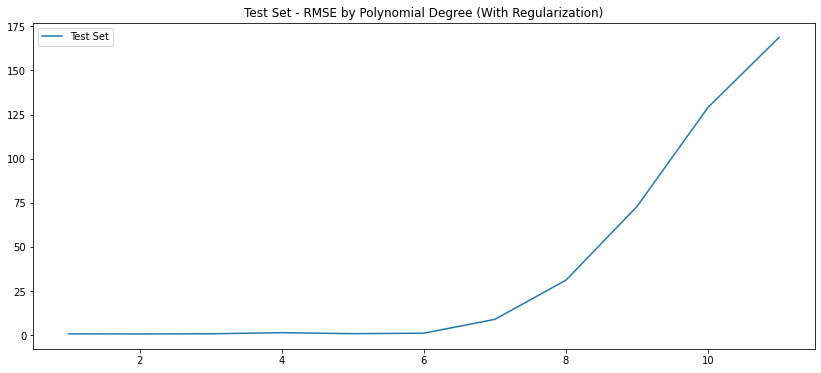

In [33]:
plt.figure(figsize=(14,6))
plt.title('Training Set - RMSE by Polynomial Degree With Regularization (lambda=0.001)')
plt.plot(range(1,12), rmse_train_list, label='Training Set')
plt.figure(figsize=(14,6))
plt.title('Test Set - RMSE by Polynomial Degree (With Regularization)')
plt.plot(range(1,12), rmse_test_list, label='Test Set')
plt.legend()
plt.show()